<a href="https://colab.research.google.com/github/HagaiHen/NewSpaceEx1/blob/main/New_Space_Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I - Algorithm Explanation

In [1]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)


#enter your foldername assignments/assignement1
FOLDERNAME = 'Vision'
              
assert FOLDERNAME is not None , "[!] Enter the foldername"

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
from pyparsing.helpers import alphanums
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import random
import math

In [3]:
# RANSAC

def draw_line(image, m, b, color=(255, 255, 255), thickness=2):
    """Draws a line on an image given a slope and y-intercept."""
    h, w = image.shape[:2]
    
    # Compute the starting and ending points of the line
    x1 = 0
    y1 = int(b)
    x2 = w - 1
    y2 = int(m * x2 + b)
    
    # Draw the line on the image
    cv.line(image, (x1, y1), (x2, y2), color, thickness)
    
    return image

def sort_top_three(lst, points_on_line, line, count):
    candidate = points_on_line, count, line
    if candidate not in lst:
      if lst[0][1] < count:
        lst[0]=candidate
      elif lst[1][1] < count:
        lst[1]=candidate
      elif lst[2][1] < count:
        lst[2]=candidate
      else:
        return lst
    return lst

def ransac_line_fit(points, threshold=20, max_iterations=5000):
    best_fit = None
    best_count = 0
    points_on_line = []
    ans=[]
    top_three = [[(0,0),0],[(0,0),0],[(0,0),0]]
    for i in range(max_iterations):
        # Randomly select two points from the set
        sample = random.sample(points, 2)
        curr_points = []
        # Fit a line to the selected points
        x1, y1, r, b = sample[0]
        x2, y2, r, b = sample[1]
        if x1 == x2:
            continue  # avoid division by zero
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        
        # Count the number of inliers
        count = 0
        for x, y, r, c in points:
            if abs(y - (m * x + b)) < threshold:
                count += 1
                curr_points.append([x,y,r,c])
        # Update the best-fit line if we found more inliers than before
        top_three = sort_top_three(top_three, curr_points, (m, b), count)
        if count > best_count and count >= 3:
            best_fit = (m, b)
            best_count = count
            points_on_line = curr_points
            ans.insert(0, best_fit)
    
    return best_fit, points_on_line, top_three

In [47]:
# Detection

def stars_detection(img):
    tmp_min = 0
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Apply a threshold to create a binary image
    ret, thresh = cv.threshold(img, 179, 255, cv.THRESH_BINARY)

    # Find contours in the binary image
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Loop through the contours and find the centers of the stars
    centers = []
    eps = 1 / 225000
    for cnt in contours:
        # Calculate the bounding box of the contour
        x,y,w,h = cv.boundingRect(cnt)

        # Check if the bounding box is too close to any of the previous centers
        too_close = False
        for center in centers:
            if abs(center[0]-x) < 50 and abs(center[1]-y) < 50:
                too_close = True
                break
        scale = img.shape[0] * img.shape[1] * eps
        if not too_close and max(w,h) < scale:
            # Calculate the center of the star
            center_x = x + w // 2
            center_y = y + h // 2
            brightness = img[center_y, center_x]
            centers.append((x, y, max(w, h), brightness))
                        
    return centers

def initial_detection(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary image
    ret, thresh = cv.threshold(img, 140, 255, cv.THRESH_BINARY)

    # Apply morphological operations
    kernel = np.ones((6,6), np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)

    # Find contours
    contours, hierarchy = cv.findContours(opening, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Loop through the contours and find the centers of the stars
    centers = []
    for cnt in contours:
        # Calculate the minimum enclosing circle of the contour
        (center_x, center_y), radius = cv.minEnclosingCircle(cnt)

        # Check if the center is too close to any of the previous centers
        too_close = False
        for center in centers:
            if abs(center[0]-center_x) < 50 and abs(center[1]-center_y) < 50:
                too_close = True
                break
        if not too_close:
            # Get the brightness value of the center pixel
            brightness = img[int(center_y), int(center_x)]

            # Add the center to the list
            centers.append((int(center_x), int(center_y), int(radius), brightness))
            
    return centers

def draw_rectangles(img, rectangles, color):
    for rect in rectangles:
      cv.rectangle(img, (rect[0]-40,rect[1]-40), (rect[0]+rect[2]+40,rect[1]+rect[2]+40), color, 7)


In [5]:
# Find matching

def draw_rectangles_manually(img, rectangles):
    for rect in rectangles:
          cv.rectangle(img, (rect[0]-40,rect[1]-40), (rect[0]+rect[2]+40,rect[1]+rect[2]+40), (0,0,0), 7)

def similarity(line_points1, line_points2):
    AB = distance(line_points2[0], line_points2[1])
    BC = distance(line_points2[1], line_points2[2])
    AC = distance(line_points2[2], line_points2[0])
    min_diff = 50000
    same_points = []
    for i in range(len(line_points1)-2):
      curr_points = []
      DE = distance(line_points1[i], line_points1[i+1])
      EF = distance(line_points1[i+1], line_points1[i+2])
      FD = distance(line_points1[i+2], line_points1[i])
      curr_points.append(line_points1[i])
      curr_points.append(line_points1[i+1])
      curr_points.append(line_points1[i+2])
      curr_diff = abs(abs(AB/DE-BC/EF) + abs(BC/EF-AC/FD) + abs(AB/DE-AC/FD))
      if curr_diff < min_diff:
        min_diff = curr_diff
        same_points = curr_points
    for point in same_points:
      point = tuple(point)

    return min_diff, same_points

def distance(point1, point2):
  x1, y1, r1, b1 = point1
  x2, y2, r2, b2 = point2
  return math.sqrt((x2-x1)**2+(y2-y1)**2)

In [6]:
# Transformation and Translation

def compute_transformation(best_correlation):
  x1_1, y1_1, r1_1, b1_1 = best_correlation[0][0]
  x1_2, y1_2, r1_2, b1_2 = best_correlation[0][1]
  x1_3, y1_3, r1_3, b1_3 = best_correlation[0][2]
  x2_1, y2_1, r2_1, b2_1 = best_correlation[1][0]
  x2_2, y2_2, r2_2, b2_2 = best_correlation[1][1]
  x2_3, y2_3, r2_3, b2_3 = best_correlation[1][2]

  # Define the points in img1 and img2 as numpy arrays
  img1_points = np.array([[x1_1, y1_1], [x1_2, y1_2], [x1_3, y1_3]])
  img2_points = np.array([[x2_1, y2_1], [x2_2, y2_2], [x2_3, y2_3]])

  # Compute the difference vectors
  v1 = img1_points[1] - img1_points[0]
  v2 = img2_points[1] - img2_points[0]

  # Compute the scaling factor
  s = np.linalg.norm(v2) / np.linalg.norm(v1)

  # Compute the rotation matrix
  v1_unit = v1 / np.linalg.norm(v1)
  v2_unit = v2 / np.linalg.norm(v2)
  cos_theta = np.dot(v1_unit, v2_unit)
  sin_theta = np.cross(v1_unit, v2_unit)
  R = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

  # Compute the translation vector
  t = img2_points[0] - s * R.dot(img1_points[0])

  return s, R, t

# Define the transformation function
def transform(x1, y1, s, R, t):
    p = np.array([x1, y1])
    p_transformed = s * R.dot(p) + t
    return p_transformed[0], p_transformed[1]

# Part II - Detection Example

* fr1.jpg
* fr2.jpg
* ST_db1.png
* ST_db2.png
* IMG_3054.jpg
* IMG_3053.jpg

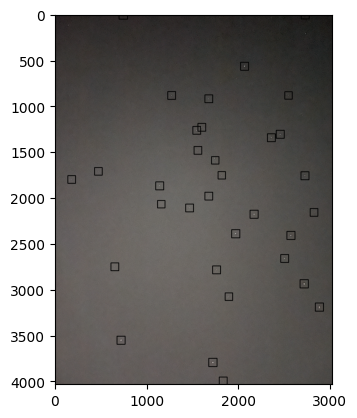

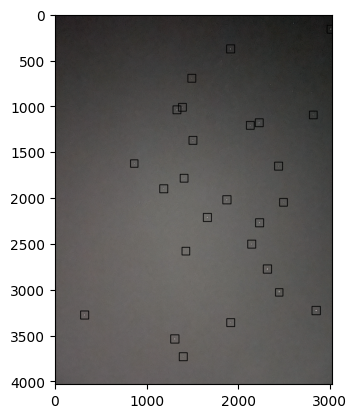

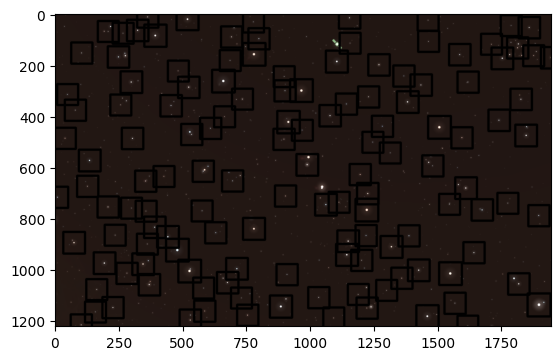

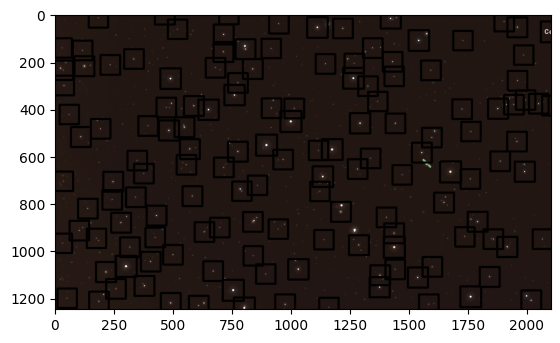

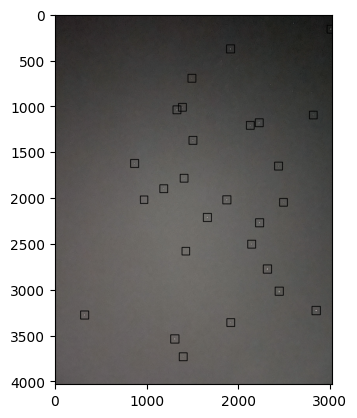

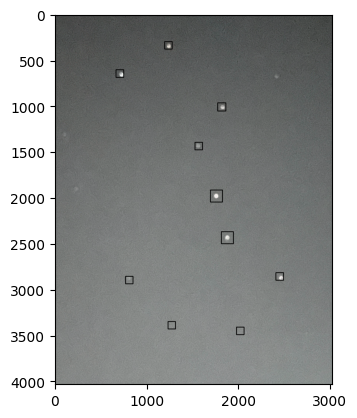

In [36]:
# Main For Show the detection part

# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/fr1.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/fr2.jpg')
img3 = cv.imread('/content/drive/MyDrive/Vision/ST_db1.png')
img4 = cv.imread('/content/drive/MyDrive/Vision/ST_db2.png')
img5 = cv.imread('/content/drive/MyDrive/Vision/IMG_3054.jpg')
img6 = cv.imread('/content/drive/MyDrive/Vision/IMG_3053.jpg')

images = [img1, img2, img3, img4, img5, img6]

for img in images:
  points = stars_detection(img)
  draw_rectangles(img, points, (0,0,0))
  plt.imshow(img), plt.show()
  


# Part IV - Matching Examples

**fr1.jpg, ST_db1.png**

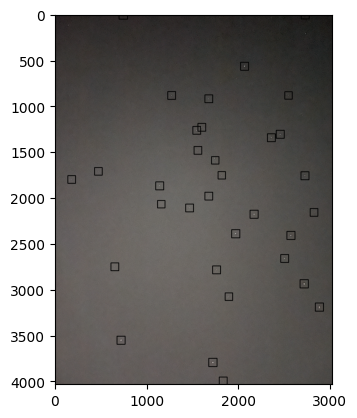

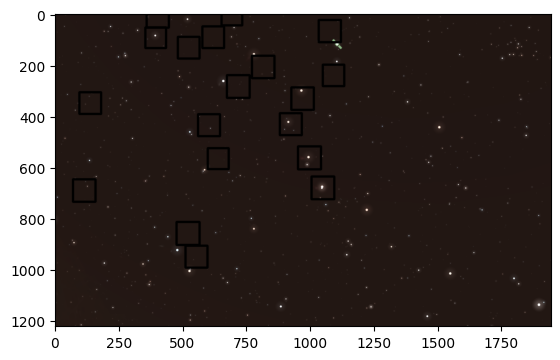

######## Correlation ########
(1826, 3996, 6, 215) => (550, 947, 6, 215)
(1712, 3792, 10, 251) => (515, 854, 10, 251)
(714, 3551, 8, 253) => (110, 687, 8, 253)
(2871, 3189, 9, 253) => (1043, 676, 9, 253)
(1890, 3079, 2, 181) => (637, 565, 2, 181)
(2705, 2935, 10, 243) => (990, 558, 10, 243)
(1754, 2785, 6, 242) => (599, 432, 6, 242)
(648, 2752, 5, 212) => (135, 346, 5, 212)
(2495, 2661, 6, 238) => (919, 428, 6, 238)
(2562, 2409, 8, 251) => (964, 327, 8, 251)
(1961, 2390, 9, 254) => (712, 279, 9, 254)
(2161, 2178, 8, 239) => (810, 203, 8, 239)
(2815, 2160, 4, 200) => (1087, 238, 4, 200)
(1461, 2111, 5, 250) => (520, 129, 5, 250)
(1155, 2072, 1, 183) => (393, 92, 1, 183)
(1670, 1982, 5, 253) => (616, 88, 5, 253)
(1135, 1869, 7, 239) => (398, 6, 7, 239)
(179, 1801, 4, 212) => (0, -85, 4, 212)
(2715, 1759, 7, 224) => (1071, 63, 7, 224)
(1813, 1757, 1, 182) => (691, 3, 1, 182)
(470, 1713, 3, 188) => (128, -103, 3, 188)
(1742, 1594, 1, 180) => (672, -70, 1, 180)
(1552, 1484, 4, 189) => (599,

In [27]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/fr1.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/ST_db1.png')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

# Transform
for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")

**fr1.jpg, ST_db2.png**

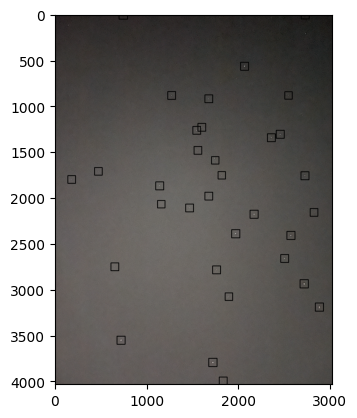

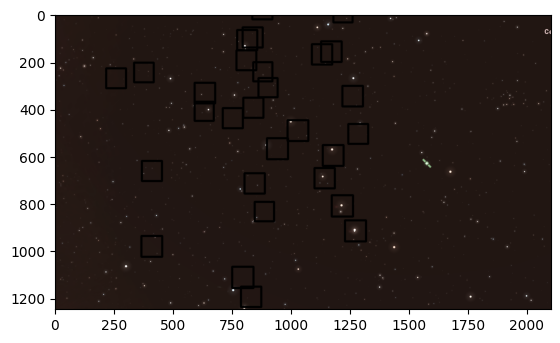

######## Correlation ########
(1826, 3996, 6, 215) => (826, 1191, 6, 215)
(1712, 3792, 10, 251) => (789, 1107, 10, 251)
(714, 3551, 8, 253) => (405, 977, 8, 253)
(2871, 3189, 9, 253) => (1266, 911, 9, 253)
(1890, 3079, 2, 181) => (884, 833, 2, 181)
(2705, 2935, 10, 243) => (1210, 805, 10, 243)
(1754, 2785, 6, 242) => (841, 712, 6, 242)
(648, 2752, 5, 212) => (407, 660, 5, 212)
(2495, 2661, 6, 238) => (1137, 690, 6, 238)
(2562, 2409, 8, 251) => (1172, 593, 8, 251)
(1961, 2390, 9, 254) => (936, 564, 9, 254)
(2161, 2178, 8, 239) => (1023, 488, 8, 239)
(2815, 2160, 4, 200) => (1280, 504, 4, 200)
(1461, 2111, 5, 250) => (749, 437, 5, 250)
(1155, 2072, 1, 183) => (630, 410, 1, 183)
(1670, 1982, 5, 253) => (836, 393, 5, 253)
(1135, 1869, 7, 239) => (630, 330, 7, 239)
(179, 1801, 4, 212) => (256, 269, 4, 212)
(2715, 1759, 7, 224) => (1255, 343, 7, 224)
(1813, 1757, 1, 182) => (900, 310, 1, 182)
(470, 1713, 3, 188) => (374, 245, 3, 188)
(1742, 1594, 1, 180) => (878, 243, 1, 180)
(1552, 1484, 4,

In [37]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/fr1.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/ST_db2.png')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")

**fr2.jpg, ST_db1.png**

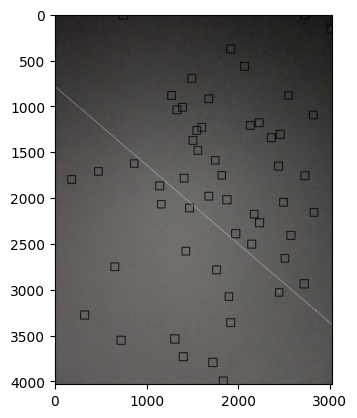

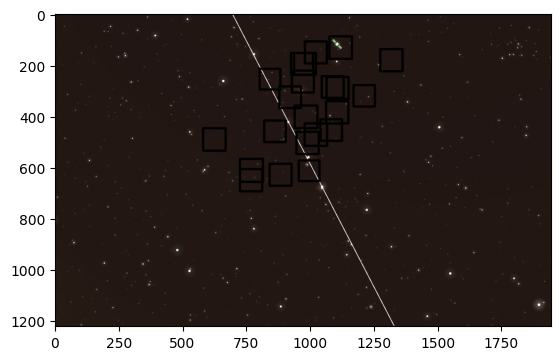

######## Correlation ########
(1391, 3731, 7, 192) => (763, 647, 7, 192)
(1298, 3536, 10, 251) => (763, 607, 10, 251)
(1908, 3360, 6, 210) => (879, 626, 6, 210)
(318, 3276, 8, 252) => (619, 487, 8, 252)
(2438, 3033, 1, 182) => (993, 613, 1, 182)
(1421, 2582, 4, 241) => (858, 457, 4, 241)
(2136, 2504, 7, 246) => (984, 501, 7, 246)
(2221, 2271, 8, 249) => (1016, 468, 8, 249)
(2483, 2050, 4, 216) => (1078, 452, 4, 216)
(1865, 2020, 9, 249) => (977, 398, 9, 249)
(1401, 1787, 5, 246) => (917, 323, 5, 246)
(2428, 1654, 7, 250) => (1100, 381, 7, 250)
(861, 1629, 1, 189) => (840, 254, 1, 189)
(1497, 1374, 6, 254) => (966, 261, 6, 254)
(2121, 1211, 5, 231) => (1083, 283, 5, 231)
(2218, 1182, 6, 241) => (1102, 286, 6, 241)
(2807, 1098, 4, 206) => (1207, 318, 4, 206)
(1323, 1041, 6, 254) => (963, 192, 6, 254)
(1383, 1014, 5, 244) => (975, 192, 5, 244)
(1485, 697, 6, 242) => (1017, 147, 6, 242)
(1906, 376, 8, 248) => (1113, 127, 8, 248)
(2999, 162, 7, 231) => (1312, 177, 7, 231)


In [17]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/fr2.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/ST_db1.png')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

draw_rectangles(img1, s_points, (0,0,0))


# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

m1, b1 = best_line[0]
m2, b2 = best_line[1]

img1 = draw_line(img1, m1, b1)
img2 = draw_line(img2, m2, b2)

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")


**fr2.jpg, ST_db2.png**




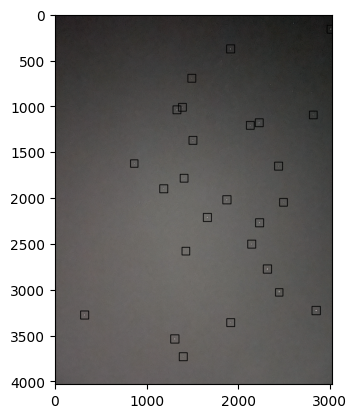

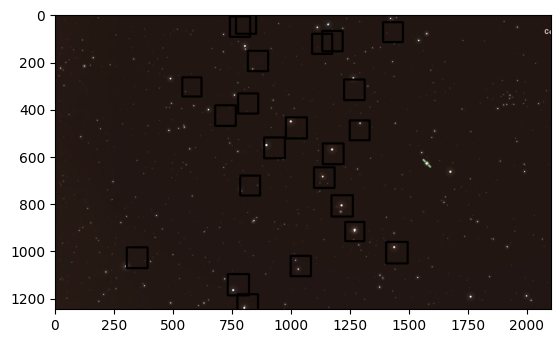

######## Correlation ########
(1391, 3731, 7, 192) => (811, 1223, 7, 192)
(1298, 3536, 10, 251) => (770, 1138, 10, 251)
(1908, 3360, 6, 210) => (1036, 1061, 6, 210)
(318, 3276, 8, 252) => (343, 1025, 8, 252)
(2835, 3226, 11, 255) => (1440, 1002, 11, 255)
(2438, 3033, 1, 182) => (1267, 918, 1, 182)
(2305, 2774, 10, 252) => (1209, 805, 10, 252)
(1421, 2582, 4, 241) => (823, 722, 4, 241)
(2136, 2504, 7, 246) => (1135, 687, 7, 246)
(2221, 2271, 8, 249) => (1172, 586, 8, 249)
(1653, 2213, 8, 255) => (924, 561, 8, 255)
(2483, 2050, 4, 216) => (1286, 489, 4, 216)
(1865, 2020, 9, 249) => (1016, 476, 9, 249)
(1179, 1901, 7, 247) => (717, 425, 7, 247)
(1401, 1787, 5, 246) => (814, 375, 5, 246)
(2428, 1654, 7, 250) => (1262, 316, 7, 250)
(861, 1629, 1, 189) => (578, 307, 1, 189)
(1497, 1374, 6, 254) => (855, 195, 6, 254)
(2121, 1211, 5, 231) => (1127, 123, 5, 231)
(2218, 1182, 6, 241) => (1170, 111, 6, 241)
(2807, 1098, 4, 206) => (1427, 74, 4, 206)
(1323, 1041, 6, 254) => (779, 50, 6, 254)
(1383

In [23]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/fr2.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/ST_db2.png')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

m1, b1 = best_line[0]
m2, b2 = best_line[1]

# img1 = draw_line(img1, m1, b1)
# img2 = draw_line(img2, m2, b2)

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")

**ST_db1.png, ST_db2.png**

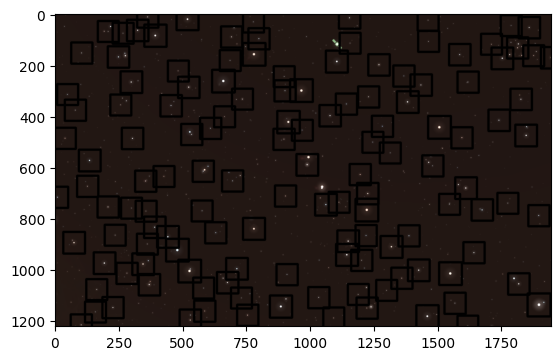

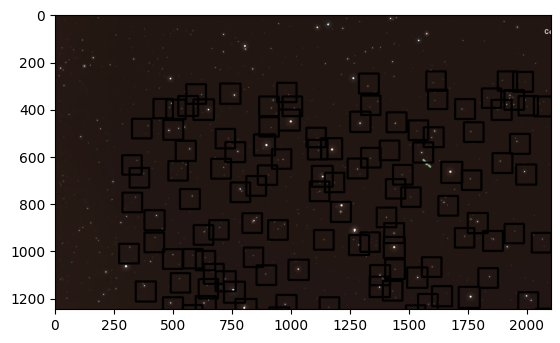

######## Correlation ########
(1614, 1221, 1, 202) => (1826, 1380, 1, 202)
(101, 1216, 3, 240) => (427, 1466, 3, 240)
(527, 1197, 4, 227) => (820, 1423, 4, 227)
(1089, 1189, 2, 187) => (1339, 1382, 2, 187)
(1453, 1180, 7, 255) => (1675, 1352, 7, 255)
(752, 1178, 3, 217) => (1027, 1392, 3, 217)
(157, 1166, 2, 158) => (476, 1417, 2, 158)
(584, 1162, 3, 194) => (870, 1388, 3, 194)
(1219, 1150, 3, 188) => (1457, 1338, 3, 188)
(225, 1148, 3, 253) => (537, 1396, 3, 253)
(880, 1142, 7, 255) => (1143, 1351, 7, 255)
(1888, 1134, 10, 255) => (2074, 1284, 10, 255)
(1563, 1131, 3, 203) => (1774, 1300, 3, 203)
(728, 1111, 2, 184) => (1000, 1332, 2, 184)
(1030, 1109, 3, 223) => (1279, 1312, 3, 223)
(1185, 1097, 2, 202) => (1422, 1292, 2, 202)
(1296, 1081, 2, 193) => (1524, 1270, 2, 193)
(162, 1078, 2, 255) => (475, 1335, 2, 255)
(580, 1072, 2, 184) => (861, 1305, 2, 184)
(367, 1058, 4, 255) => (663, 1304, 4, 255)
(1812, 1055, 4, 255) => (1999, 1215, 4, 255)
(673, 1050, 4, 255) => (946, 1279, 4, 255)

In [24]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/ST_db1.png')
img2 = cv.imread('/content/drive/MyDrive/Vision/ST_db2.png')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

m1, b1 = best_line[0]
m2, b2 = best_line[1]

# img1 = draw_line(img1, m1, b1)
# img2 = draw_line(img2, m2, b2)

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")

**fr1.jpg, fr2.jpg**

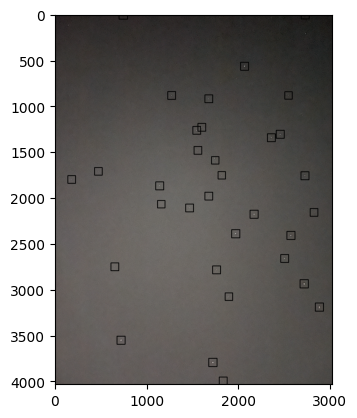

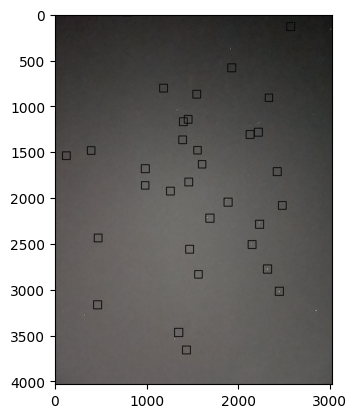

######## Correlation ########
(1826, 3996, 6, 215) => (1426, 3658, 6, 215)
(1712, 3792, 10, 251) => (1340, 3465, 10, 251)
(714, 3551, 8, 253) => (459, 3165, 8, 253)
(2871, 3189, 9, 253) => (2435, 3017, 9, 253)
(1890, 3079, 2, 181) => (1559, 2836, 2, 181)
(2705, 2935, 10, 243) => (2306, 2774, 10, 243)
(1754, 2785, 6, 242) => (1461, 2560, 6, 242)
(648, 2752, 5, 212) => (466, 2438, 5, 212)
(2495, 2661, 6, 238) => (2140, 2509, 6, 238)
(2562, 2409, 8, 251) => (2221, 2287, 8, 251)
(1961, 2390, 9, 254) => (1680, 2220, 9, 254)
(2161, 2178, 8, 239) => (1878, 2046, 8, 239)
(2815, 2160, 4, 200) => (2470, 2084, 4, 200)
(1461, 2111, 5, 250) => (1252, 1927, 5, 250)
(1155, 2072, 1, 183) => (980, 1867, 1, 183)
(1670, 1982, 5, 253) => (1452, 1828, 5, 253)
(1135, 1869, 7, 239) => (978, 1682, 7, 239)
(179, 1801, 4, 212) => (121, 1542, 4, 212)
(2715, 1759, 7, 224) => (2413, 1714, 7, 224)
(1813, 1757, 1, 182) => (1599, 1637, 1, 182)
(470, 1713, 3, 188) => (391, 1486, 3, 188)
(1742, 1594, 1, 180) => (1549, 

In [26]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/fr1.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/fr2.jpg')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

m1, b1 = best_line[0]
m2, b2 = best_line[1]

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")

**IMG_3053.jpg, IMG_3054.jpg**

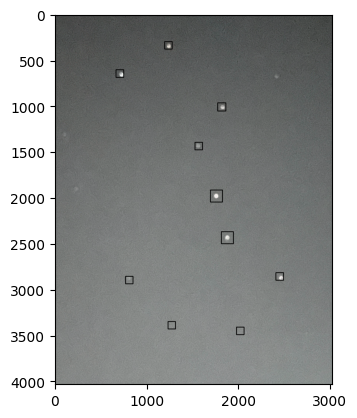

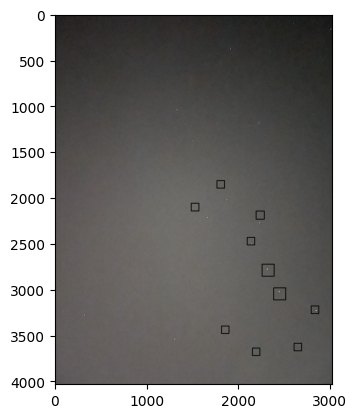

######## Correlation ########
(2014, 3452, 2, 180) => (2640, 3628, 2, 180)
(1269, 3391, 1, 181) => (2187, 3680, 1, 181)
(807, 2899, 1, 180) => (1851, 3440, 1, 180)
(2442, 2858, 3, 187) => (2826, 3221, 3, 187)
(1849, 2412, 51, 234) => (2418, 3024, 51, 234)
(1730, 1958, 51, 247) => (2292, 2766, 51, 247)
(1562, 1438, 2, 180) => (2130, 2474, 2, 180)
(1809, 1008, 9, 190) => (2227, 2187, 9, 190)
(703, 647, 4, 182) => (1521, 2102, 4, 182)
(1232, 340, 2, 179) => (1801, 1855, 2, 179)


In [52]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/IMG_3053.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/IMG_3054.jpg')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x, y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")